# TASK #1: UNDERSTAND THE PROBLEM STATEMENT AND BUSINESS CASE

- Artificial intelligence has been revolutionizing healthcare and medicine in many area such as: (1) Medical Imagery , (2) Drug Research, and (3) Genome Development.

- Deep Learning has been proven to be superior in detecting and classifying disease using imagery data. For example, skin cancer could be detected more accurately by deep learning than by dermatologists(2018).
    - Human dermatologists detection = 86.6%
    - Deep Learning detection = 95%
- In this case study, we will automate the process of detecting and classifying chest disease from X-Ray images to reduce the cost and time of detection

- Dataset contains 133 images that belong to 4 classes
    - Healthy
    - Covid-19
    - Bacterial Pneumonia
    - Viral Pneumonia

# TASK #2: IMPORTING DATASETS AND LIBRARIES

In [ ]:
import os
# import cv2
import tensorflow as tf
import numpy as np
from tensorflow.keras import layers, optimizers
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.layers import Input, Add, Dense, Activation, ZeroPadding2D, BatchNormalization, Flatten, Conv2D, AveragePooling2D, MaxPooling2D, Dropout
from tensorflow.keras.models import Model, load_model
from tensorflow.keras import backend as K
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint, LearningRateScheduler
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

from jupyterthemes import jtplot
jtplot.style(theme = 'monokai', context = 'notebook', ticks = True, grid = False) 
# setting the style of the notebook to be monokai theme  
# this line of code is important to ensure that we are able to see the x and y axes clearly
# If you don't run this code line, you will notice that the xlabel and ylabel on any plot is black on black and it will be hard to see them. 

In [2]:
# Specify training data directory
XRay_Directory = 'Chest_X_Ray/train'

In [3]:
# List the folders in the directory
os.listdir(XRay_Directory)

['0', '1', '2', '3']

In [4]:
# Use image generator to generate tensor images data and normalize them
# Use 20% of the data for cross-validation  
image_generator = ImageDataGenerator(rescale = 1/255, validation_split = 0.2)

In [5]:
# Generate batches of 40 images
# Total number of images is 133*4 = 532 images
# Training is 428 (80%) and validation is 104 (20%)
# Perform shuffling and image resizing

train_generator = image_generator.flow_from_directory(batch_size = 40,
                                                     directory = XRay_Directory,
                                                     shuffle = True,
                                                     target_size=(256,256),
                                                     class_mode='categorical',
                                                     subset = 'training')

Found 428 images belonging to 4 classes.


In [6]:
validation_generator = image_generator.flow_from_directory(batch_size = 40,
                                                           directory = XRay_Directory, 
                                                           shuffle = True, 
                                                           target_size = (256,256), 
                                                           class_mode = 'categorical', 
                                                           subset = "validation")


Found 104 images belonging to 4 classes.


In [7]:
# Generate a batch of 40 images and labels
!pip install pillow
train_images, train_labels = next(train_generator)


You should consider upgrading via the 'c:\users\administrator\appdata\local\programs\python\python37\python.exe -m pip install --upgrade pip' command.


In [8]:
train_labels

array([[0., 1., 0., 0.],
       [0., 0., 1., 0.],
       [0., 0., 1., 0.],
       [0., 0., 1., 0.],
       [1., 0., 0., 0.],
       [1., 0., 0., 0.],
       [0., 0., 1., 0.],
       [0., 0., 0., 1.],
       [0., 0., 0., 1.],
       [1., 0., 0., 0.],
       [0., 0., 0., 1.],
       [0., 0., 1., 0.],
       [0., 0., 1., 0.],
       [0., 1., 0., 0.],
       [0., 0., 1., 0.],
       [0., 1., 0., 0.],
       [0., 0., 1., 0.],
       [0., 1., 0., 0.],
       [0., 0., 0., 1.],
       [1., 0., 0., 0.],
       [0., 0., 0., 1.],
       [0., 1., 0., 0.],
       [1., 0., 0., 0.],
       [0., 1., 0., 0.],
       [0., 0., 1., 0.],
       [0., 1., 0., 0.],
       [0., 1., 0., 0.],
       [0., 1., 0., 0.],
       [0., 0., 0., 1.],
       [1., 0., 0., 0.],
       [0., 0., 1., 0.],
       [0., 0., 1., 0.],
       [0., 1., 0., 0.],
       [0., 1., 0., 0.],
       [0., 0., 0., 1.],
       [1., 0., 0., 0.],
       [0., 0., 1., 0.],
       [0., 1., 0., 0.],
       [0., 0., 0., 1.],
       [1., 0., 0., 0.]],

In [9]:
# labels Translator 
label_names = {0 : 'Covid-19', 1 : 'Normal' , 2: 'Viral Pneumonia', 3 : 'Bacterial Pneumonia'}

# TASK #3: PERFORM DATA VISUALIZATION

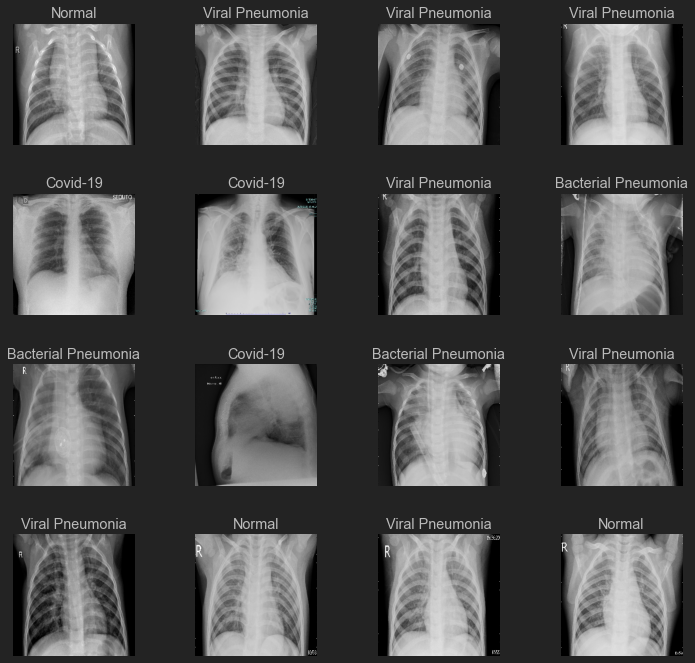

In [10]:
# Create a grid of 16 images along with their corresponding labels
L = 4
W = 4

fig, axes = plt.subplots(L, W, figsize = (12, 12))
axes = axes.ravel()

for i in np.arange(0, L*W):
    axes[i].imshow(train_images[i])
    axes[i].set_title(label_names[np.argmax(train_labels[i])])
    axes[i].axis('off')
plt.subplots_adjust(wspace = 0.5)    

# TASK #4: IMPORT MODEL WITH PRETRAINED WEIGHTS

In [13]:
basemodel = ResNet50(weights = 'imagenet', include_top = False, input_tensor = Input(shape = (256,256,3)))

In [14]:
basemodel.summary()

Model: "resnet50"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 262, 262, 3)  0           input_2[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 128, 128, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 128, 128, 64) 256         conv1_conv[0][0]                 
___________________________________________________________________________________________

In [15]:
#freezing the model upto the last stage - 4 and re-training stage -5 

for layer in basemodel.layers[:-10]:
  layers.trainable = False

# TASK #5: TRAIN RESNET MODEL WITH THE NEW DATASETS

In [16]:
headmodel = basemodel.output
headmodel = AveragePooling2D(pool_size = (4,4))(headmodel)
headmodel = Flatten(name = 'flatten')(headmodel)
headmodel = Dense(256, activation = 'relu')(headmodel)
headmodel = Dropout(0.3)(headmodel)
headmodel = Dense(128, activation = 'relu')(headmodel)
headmodel = Dropout(0.2)(headmodel)

headmodel = Dense(4, activation = 'softmax')(headmodel)

model = Model(inputs = basemodel.input, outputs = headmodel)

In [17]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 262, 262, 3)  0           input_2[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 128, 128, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 128, 128, 64) 256         conv1_conv[0][0]                 
______________________________________________________________________________________________

In [18]:
model.compile(loss = 'categorical_crossentropy', optimizer = optimizers.RMSprop(learning_rate = 1e-4, decay = 1e-6), metrics= ["accuracy"])

In [19]:
# using early stopping to exit training if validation loss is not decreasing even after certain epochs (patience)
earlystopping = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=20)

# save the best model with lower validation loss
checkpointer = ModelCheckpoint(filepath="weights.hdf5", verbose=1, save_best_only=True)

In [20]:
train_generator = image_generator.flow_from_directory(batch_size = 4, directory= XRay_Directory, shuffle= True, target_size=(256,256), class_mode= 'categorical', subset="training")
val_generator = image_generator.flow_from_directory(batch_size = 4, directory= XRay_Directory, shuffle= True, target_size=(256,256), class_mode= 'categorical', subset="validation")

Found 428 images belonging to 4 classes.
Found 104 images belonging to 4 classes.


In [21]:
history = model.fit(train_generator, steps_per_epoch= train_generator.n // 4, epochs = 1, validation_data= val_generator, validation_steps= val_generator.n // 4, callbacks=[checkpointer, earlystopping])

  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 107 steps, validate for 26 steps
106/107 [============================>.] - ETA: 7s - loss: 0.8039 - accuracy: 0.7146 
Epoch 00001: val_loss improved from inf to 5.33595, saving model to weights.hdf5
107/107 [==============================] - 805s 8s/step - loss: 0.8127 - accuracy: 0.7150 - val_loss: 5.3360 - val_accuracy: 0.2500


In [22]:
# serialize model to JSON
model_json = model.to_json()
with open("model.json", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
model.save_weights("model.h5")
print("Saved model to disk")

Saved model to disk


In [22]:
# load json and create model

from tensorflow.keras.models import model_from_json

json_file = open('model.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
model = model_from_json(loaded_model_json)
# load weights into new model
model.load_weights("chestdisease_trained_model.h5")
print("Loaded model from disk")


Loaded model from disk


# TASK #6: EVALUATE TRAINED DEEP LEARNING MODEL

In [25]:
# Let's compile the model 
model.compile(optimizer = tf.keras.optimizers.RMSprop(0.0001, decay = 1e-6), loss = 'categorical_crossentropy', metrics = ['accuracy'])

In [26]:
test_directory = 'Chest_X_Ray/Test'


In [27]:
test_gen = ImageDataGenerator(rescale = 1./255)

test_generator = test_gen.flow_from_directory(batch_size = 40, directory= test_directory, shuffle= True, target_size=(256,256), class_mode= 'categorical')

evaluate = model.evaluate_generator(test_generator, steps = test_generator.n // 4, verbose =1)

print('Accuracy Test : {}'.format(evaluate[1]))

Found 40 images belonging to 4 classes.
Instructions for updating:
Please use Model.evaluate, which supports generators.
  ...
    to  
  ['...']
 1/10 [==>...........................] - ETA: 1:32 - loss: 1.3360 - accuracy: 0.8000Accuracy Test : 0.800000011920929


In [28]:
!pip install opencv-python

You should consider upgrading via the 'c:\users\administrator\appdata\local\programs\python\python37\python.exe -m pip install --upgrade pip' command.


In [29]:
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
import cv2
prediction = []
original = []
image = []

for i in range(len(os.listdir(test_directory))):
  for item in os.listdir(os.path.join(test_directory,str(i))):
    img= cv2.imread(os.path.join(test_directory,str(i),item))
    img = cv2.resize(img,(256,256))
    image.append(img)
    img = img / 255
    img = img.reshape(-1,256,256,3)
    predict = model.predict(img)
    predict = np.argmax(predict)
    prediction.append(predict)
    original.append(i)

In [30]:
len(original)

40

In [31]:
score = accuracy_score(original,prediction)
print("Test Accuracy : {}".format(score))

Test Accuracy : 0.775


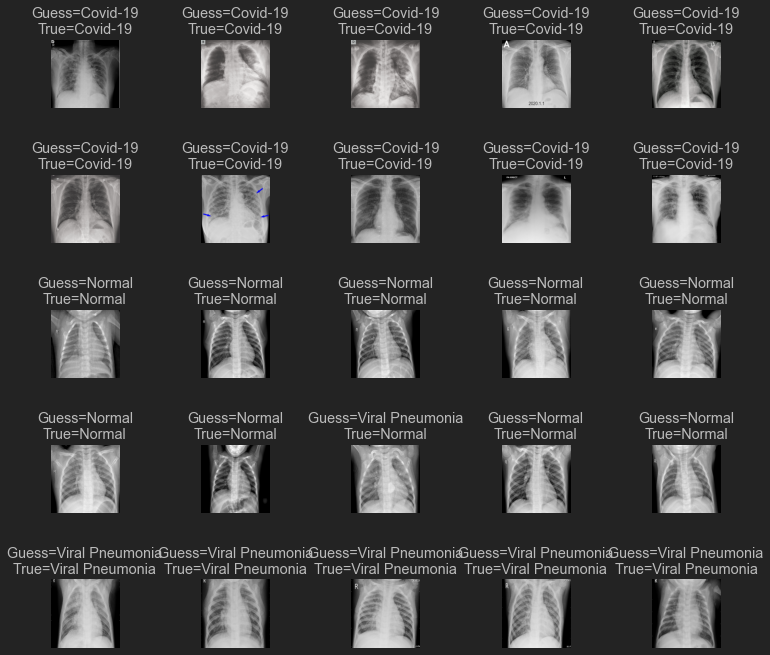

In [32]:
L = 5
W = 5

fig, axes = plt.subplots(L, W, figsize = (12, 12))
axes = axes.ravel()

for i in np.arange(0, L*W):
    axes[i].imshow(image[i])
    axes[i].set_title('Guess={}\nTrue={}'.format(str(label_names[prediction[i]]), str(label_names[original[i]])))
    axes[i].axis('off')

plt.subplots_adjust(wspace = 1.2) 

In [33]:
print(classification_report(np.asarray(original), np.asarray(prediction)))

              precision    recall  f1-score   support

           0       0.77      1.00      0.87        10
           1       0.82      0.90      0.86        10
           2       0.67      0.60      0.63        10
           3       0.86      0.60      0.71        10

    accuracy                           0.78        40
   macro avg       0.78      0.78      0.77        40
weighted avg       0.78      0.78      0.77        40



Text(0.5, 1.0, 'Confusion_matrix')

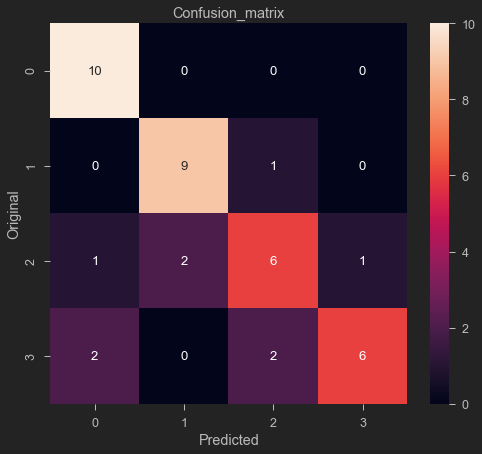

In [34]:
cm = confusion_matrix(np.asarray(original), np.asarray(prediction))
ax = plt.subplot()
sns.heatmap(cm, annot = True, ax = ax)

ax.set_xlabel('Predicted')
ax.set_ylabel('Original')
ax.set_title('Confusion_matrix')